# Model

## Imports

In [1180]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

## Functions

In [1183]:
def add_diagnosis_to_cats(cats, diag):
    if ',' in diag:
        split_diag = diag.split(',')
        for value in split_diag:
            value = value.strip()
            if value not in cats and value != '':
                cats.append(value)
    elif diag.strip() not in cats and diag.strip() != '':
        cats.append(diag.strip())

In [1185]:
def get_diag_categories(df_cp, column_name):
    cats = []
    for i in range(len(df_cp[column_name])):
        if df_cp[column_name][i] != -1:
            diag = str(df_cp[column_name][i])
            add_diagnosis_to_cats(cats, diag)
    return cats

In [1187]:
def create_count_dict_for_cat_list(cats):
    count_dict = {}
    count_dict = dict(zip(cats, [0] * len(cats)))
    return count_dict

In [1189]:
def add_value_to_cat_dict(diag, cats, cat_dict_cp):
    if ',' in diag:
        split_diag = diag.split(',')
        for value in split_diag:
            value = value.strip()
            if value in cats and value != '':
                cat_dict_cp[value] += 1
    elif diag.strip() in cats and diag.strip() != '':
        cat_dict_cp[diag.strip()] += 1

In [1191]:
def get_diag_counts_for_each_category(df_cp, cats, column_name):
    er_counts_dict = create_count_dict_for_cat_list(cats)
    for i in range(len(df_cp[column_name])):
        if df_cp[column_name][i] != -1:
            diag = str(df_cp[column_name][i])
            add_value_to_cat_dict(diag, cats, er_counts_dict)
    return er_counts_dict

In [1193]:
def check_and_replace_values_in_column_by_list(df_cp, desired_values_list, column_name, replacing_val):
    for i in range(len(df_cp[column_name])):
        diag = str(df_cp[column_name][i])
        if ',' in diag:
            split_diag = diag.split(',')
            for value in split_diag:
                replace = True
                value = value.strip()
                if value in desired_values_list and value != '' and not value.isspace():
                    df_cp.loc[i, column_name] = value.strip()
                    replace = False
                    break;
                if replace: 
                    df_cp.loc[i, column_name] = replacing_val.strip()
        elif diag.strip() not in desired_values_list and diag.strip() != '' and not diag.isspace():
            df_cp.loc[i, column_name] = replacing_val.strip()
        elif diag.strip() == '':
            df_cp.loc[i, column_name] = replacing_val.strip()
        else:
            df_cp.loc[i, column_name] = diag.strip()

In [1195]:
def calculate_optimal_split(df, column_name, number_of_quartiles):
    quantiles = np.linspace(0, 100, number_of_quartiles + 1)
    quartiles = np.percentile(df[column_name], quantiles)
    
    bin_edges = [df[column_name].min()] + list(quartiles[1:-1]) + [
        df[column_name].max()]
    
    return bin_edges

In [1197]:
def calculate_input_size(df_copy, numeric_columns, categorical_columns):
    # Initialize the transformers
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(sparse_output=False)  # One-hot encoding

    # Create a column transformer to process numeric and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    # Fit and transform the data (without doctor column)
    X_processed = preprocessor.fit_transform(df_copy)

    # Return the number of features after preprocessing
    return X_processed.shape[1]

# Now calculate the input size after preprocessing
input_size_after_preprocessing = calculate_input_size(df_copy, numeric_columns=numerical_cols, categorical_columns=categorical_cols)
print(f"Input size after preprocessing: {input_size_after_preprocessing}")

Input size after preprocessing: 7


In [1199]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="viridis", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

## Class

In [1202]:
class HospitalizationPredictionNN(nn.Module):
    def __init__(self, input_size, num_doctors, embedding_dim, hidden_size, output_size):
        super(HospitalizationPredictionNN, self).__init__()

        # Embedding layer for doctor ID
        self.embedding = nn.Embedding(num_doctors, embedding_dim)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, doctor_id):
        # Get doctor embedding
        doctor_embedding = self.embedding(doctor_id)

        # Concatenate doctor embedding with the input features
        x = torch.cat([x, doctor_embedding], dim=1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [1204]:
class NNHospitalizationPredictor:
    def __init__(self, input_size, num_doctors, embedding_dim=10, hidden_size=64, output_size=3, learning_rate=0.001, num_epochs=1000, encoding='onehot'):
        total_input_size = input_size + embedding_dim
        
        self.input_size = input_size
        self.num_doctors = num_doctors
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.encoding = encoding

        # Initialize the model with embedding for doctor IDs
        self.model = HospitalizationPredictionNN(total_input_size, num_doctors, embedding_dim, hidden_size, output_size)

        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Initialize column transformers for scaling numeric and encoding categorical data
        self.numeric_transformer = StandardScaler()
        if encoding == 'onehot':
            self.categorical_transformer = OneHotEncoder(sparse_output=False)
        elif encoding == 'ordinal':
            self.categorical_transformer = OrdinalEncoder()

        # Initialize encoder for doctor ID
        self.doctor_encoder = LabelEncoder()

    # This method scales the numerical features and encodes the categorical features.
    def preprocess_data(self, x, y, doctor_column, numeric_columns, categorical_columns):
        # Apply scaling to numeric columns and encoding to categorical columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', self.numeric_transformer, numeric_columns),
                ('cat', self.categorical_transformer, categorical_columns)
            ]
        )

        # Transform the input features (scale numerical and encode categorical)
        x_preprocessed = preprocessor.fit_transform(x)

        # Encode the doctor IDs
        doctor_encoded = self.doctor_encoder.fit_transform(doctor_column)

        y_array = y.to_numpy() if isinstance(y, pd.Series) else y

        # Encode the target variable based on selected encoding method
        if self.encoding == 'onehot':
            y_encoded = OneHotEncoder(sparse_output=False).fit_transform(y_array.reshape(-1, 1))
        elif self.encoding == 'ordinal':
            y_encoded = OrdinalEncoder().fit_transform(y_array.reshape(-1, 1)).astype(int).flatten()

        return x_preprocessed, doctor_encoded, y_encoded

    # Split the data into train and test sets.
    def split_data(self, X, doctor, y, test_size=0.2):
        return train_test_split(X, doctor, y, test_size=test_size, random_state=42)

    # Train the model.
    def train(self, x_train, doctor_train, y_train):
        # Convert data to torch tensors
        x_train_tensor = torch.FloatTensor(x_train)
        doctor_train_tensor = torch.LongTensor(doctor_train)

        # Adjust label format based on encoding
        if self.encoding == 'onehot':
            y_train_tensor = torch.LongTensor(y_train.argmax(axis=1))
        elif self.encoding == 'ordinal':
            y_train_tensor = torch.LongTensor(y_train)

        for epoch in range(self.num_epochs):
            self.model.train()

            # Forward pass
            outputs = self.model(x_train_tensor, doctor_train_tensor)
            loss = self.criterion(outputs, y_train_tensor)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model's accuracy on the test set.
    def evaluate(self, x_test, doctor_test, y_test):
        self.model.eval()

        # Convert data to torch tensors
        x_test_tensor = torch.FloatTensor(x_test)
        doctor_test_tensor = torch.LongTensor(doctor_test)

        # Adjust label format based on encoding
        if self.encoding == 'onehot':
            y_test_tensor = torch.LongTensor(y_test.argmax(axis=1))
        elif self.encoding == 'ordinal':
            y_test_tensor = torch.LongTensor(y_test)

        with torch.no_grad():
            # Get predictions
            test_outputs = self.model(x_test_tensor, doctor_test_tensor)
            _, predicted = torch.max(test_outputs, 1)

            # Calculate accuracy
            accuracy = accuracy_score(y_test_tensor, predicted)
            print(f'Accuracy: {accuracy * 100:.2f}%')

        # Return the predictions and ground truth labels
        return predicted, y_test_tensor

## Load Clean Dataset

In [1329]:
df = pd.read_csv('hospitalization2_team_10.csv')

In [1331]:
df_copy = df.copy()

## Preprocess Data

We know that the optimal split for 3 groups is 0-1 days for 'short', 1-3 days for 'mid' and 3-50 days 'long'. This can be viewed in task 17 where the optimal split for admission days in first and second hospitalization.

We will use this information to encode the data accordingly in order for it to be then inseted into the model.

After the encoding for these categories we can remove the unessecary columns.

In [1335]:
df_copy.drop(columns = ['Admission_Entry_Date', 'Release_Date', 'Admission_Entry_Date2', 'Release_Date2'], inplace=True)

We will now check what are the 4 most common diagnosis and encode the columns to be one of them if they are contained in the row and -1 in the rows that do not contain them. 

In [1341]:
diag_in_rel_categories = get_diag_categories(df_copy, 'Diagnosis_In_Release')

In [1343]:
diag_in_rec_categories = get_diag_categories(df_copy, 'Diagnosis_In_Reception')

In [1345]:
counts_dict_diag_in_rel = get_diag_counts_for_each_category(df_copy, diag_in_rel_categories, 'Diagnosis_In_Release')
counts_dict_diag_in_rec = get_diag_counts_for_each_category(df_copy, diag_in_rec_categories, 'Diagnosis_In_Reception')

In [1346]:
sorted_counts_dict_diag_in_rel = dict(sorted(counts_dict_diag_in_rel.items(), key=lambda x:x[1], reverse=True))
sorted_counts_dict_diag_in_rel

{'O8889': 724,
 '78609': 677,
 '78060': 545,
 'INT1': 502,
 '2859': 425,
 '7865': 405,
 '486': 390,
 '4280': 380,
 '5849': 349,
 '514': 311,
 '7895': 295,
 '5119': 277,
 '5990': 241,
 '42731': 241,
 '5070': 238,
 '7907': 224,
 '-1': 219,
 '78552': 212,
 '7807': 206,
 '797': 204,
 '2761': 184,
 '5184': 174,
 '99591': 169,
 '7802': 137,
 '584': 133,
 '0389': 132,
 '079.84': 124,
 '7860': 104,
 '2767': 104,
 '41071': 103,
 'V73.70': 101,
 '586': 101,
 '7806': 100,
 '43491': 99,
 '78791': 98,
 '27651': 91,
 '496': 90,
 'Z0066': 82,
 '2768': 80,
 'Z9392': 71,
 '7823': 71,
 'V4582': 70,
 '5789': 63,
 '682': 63,
 '79.84': 62,
 '5640': 61,
 '49121': 60,
 '5856': 59,
 '78900': 56,
 '2809': 56,
 '51881': 56,
 '2760': 56,
 '7070': 54,
 '2512': 52,
 'Z8857': 52,
 'E888': 50,
 '4241': 49,
 '428': 46,
 '78703': 45,
 '7882': 45,
 '4919': 44,
 '78820': 43,
 '6829': 39,
 '27542': 37,
 '7804': 36,
 '7862': 36,
 '4149': 36,
 '5722': 35,
 '78906': 35,
 '4019': 34,
 'Z3995': 34,
 '5997': 33,
 '5996': 33,
 

In [1349]:
sorted_counts_dict_diag_in_rec = dict(sorted(counts_dict_diag_in_rec.items(), key=lambda x:x[1], reverse=True))
sorted_counts_dict_diag_in_rec

{'78609': 837,
 '78060': 617,
 'O8889': 530,
 '7865': 449,
 '2859': 335,
 '486': 313,
 '7895': 292,
 '5849': 252,
 '4280': 249,
 '7807': 233,
 '514': 230,
 '-1': 219,
 '797': 210,
 '5119': 209,
 '5990': 183,
 '2761': 177,
 '42731': 166,
 '5184': 162,
 '5070': 161,
 '78552': 140,
 '7802': 136,
 '7860': 127,
 '7806': 123,
 '99591': 121,
 '7907': 102,
 '78791': 97,
 '584': 94,
 '2767': 90,
 '7823': 87,
 '43491': 83,
 'V73.70': 77,
 '389': 76,
 '78900': 74,
 '496': 70,
 '79.84': 69,
 'Z0066': 66,
 '27651': 63,
 'V4582': 63,
 '41071': 60,
 '586': 60,
 '2768': 55,
 '78703': 53,
 '682': 52,
 '49121': 49,
 '0389': 48,
 '51881': 48,
 '7862': 47,
 '2512': 47,
 '2760': 47,
 'E888': 46,
 '5640': 45,
 '5789': 42,
 'INT1': 41,
 'Z9392': 39,
 'Z8857': 39,
 '079.84': 37,
 '7804': 36,
 '78906': 36,
 '2809': 34,
 '79091': 34,
 '6829': 33,
 '4359': 33,
 '78701': 31,
 '4019': 30,
 '2989': 30,
 '7890': 30,
 '49391': 29,
 '2707 1': 28,
 '5997': 28,
 '78820': 28,
 '4919': 28,
 'V718': 28,
 '78605': 27,
 '780

In [1351]:
most_common_diags_rel = []
most_common_diags_rec = []
for i in range(3):
    most_common_diags_rel.append(list(sorted_counts_dict_diag_in_rel.keys())[i])
    most_common_diags_rec.append(list(sorted_counts_dict_diag_in_rec.keys())[i])

print(most_common_diags_rel)
print(most_common_diags_rec)

['O8889', '78609', '78060']
['78609', '78060', 'O8889']


In [1353]:
check_and_replace_values_in_column_by_list(df_copy, most_common_diags_rel, 'Diagnosis_In_Release', 'Other')

In [1354]:
check_and_replace_values_in_column_by_list(df_copy, most_common_diags_rec, 'Diagnosis_In_Reception', 'Other')

In [1355]:
df_copy['Diagnosis_In_Release'].unique()

array(['Other', '78060', 'O8889', '78609'], dtype=object)

In [1356]:
df_copy['Diagnosis_In_Reception'].unique()

array(['Other', '78060', 'O8889', '78609'], dtype=object)

In [1357]:
df_copy['Diagnosis_In_Release'].value_counts()

Diagnosis_In_Release
Other    7044
O8889     679
78609     647
78060     545
Name: count, dtype: int64

In [1358]:
df_copy['Diagnosis_In_Reception'].value_counts()

Diagnosis_In_Reception
Other    6983
78609     800
78060     617
O8889     515
Name: count, dtype: int64

In [1359]:
df_copy

,unitName1,unitName2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Admission_Days,Period_Between_Admissions
0,5,5,urgent,home,home,11023,1,Other,Other,0,3,short
1,4,4,urgent,home,home,12517,1,78060,78060,0,1,long
2,5,5,urgent,home,home,11887,2,Other,Other,0,2,short
3,3,3,urgent,home,home,10525,4,Other,Other,0,5,long
4,1,1,urgent,home,home,6890,2,Other,Other,1,2,mid
...,...,...,...,...,...,...,...,...,...,...,...,...
8910,3,3,urgent,home,institude,10126,3,Other,Other,1,4,long
8911,1,1,urgent,home,home,6888,4,Other,Other,0,1,long
8912,2,2,urgent,home,home,1769,7,Other,Other,0,1,mid
8913,1,1,urgent,home,home,7993,5,Other,Other,0,2,long


In [1360]:
period_between_addmissions = df_copy['Period_Between_Admissions'].copy()
doctor_col = df_copy['Releasing_Doctor'].copy()
df_copy.drop(columns=['Releasing_Doctor', 'Period_Between_Admissions'], inplace=True)

In [1361]:
categorical_cols = ['unitName1', 'unitName2' ,'Entry_Type', 'Patient_Origin', 'Release_Type', 'Diagnosis_In_Reception', 'Diagnosis_In_Release', 'ct']
numerical_cols = ['Admission_Days', 'Admission_Days2']

In [1362]:
num_doctors = len(set(doctor_col))
num_doctors

214

In [1363]:
input_size = calculate_input_size(df_copy, numerical_cols, categorical_cols)
input_size

32

In [1364]:
predictor = NNHospitalizationPredictor(input_size=input_size, num_doctors=num_doctors, embedding_dim=10, num_epochs=3000)

In [1365]:
X_processed, doctor_encoded, y_processed = predictor.preprocess_data(df_copy, period_between_addmissions, doctor_col, numeric_columns=numerical_cols, categorical_columns=categorical_cols)

In [1366]:
X_train, X_test, doctor_train, doctor_test, y_train, y_test = predictor.split_data(X_processed, doctor_encoded, y_processed)

In [1368]:
predictor.train(X_train, doctor_train, y_train)

Epoch [10/3000], Loss: 1.0961
Epoch [20/3000], Loss: 1.0942
Epoch [30/3000], Loss: 1.0916
Epoch [40/3000], Loss: 1.0883
Epoch [50/3000], Loss: 1.0844
Epoch [60/3000], Loss: 1.0798
Epoch [70/3000], Loss: 1.0745
Epoch [80/3000], Loss: 1.0686
Epoch [90/3000], Loss: 1.0620
Epoch [100/3000], Loss: 1.0550
Epoch [110/3000], Loss: 1.0474
Epoch [120/3000], Loss: 1.0395
Epoch [130/3000], Loss: 1.0311
Epoch [140/3000], Loss: 1.0229
Epoch [150/3000], Loss: 1.0151
Epoch [160/3000], Loss: 1.0075
Epoch [170/3000], Loss: 0.9999
Epoch [180/3000], Loss: 0.9926
Epoch [190/3000], Loss: 0.9855
Epoch [200/3000], Loss: 0.9790
Epoch [210/3000], Loss: 0.9729
Epoch [220/3000], Loss: 0.9669
Epoch [230/3000], Loss: 0.9612
Epoch [240/3000], Loss: 0.9564
Epoch [250/3000], Loss: 0.9512
Epoch [260/3000], Loss: 0.9465
Epoch [270/3000], Loss: 0.9425
Epoch [280/3000], Loss: 0.9387
Epoch [290/3000], Loss: 0.9351
Epoch [300/3000], Loss: 0.9316
Epoch [310/3000], Loss: 0.9284
Epoch [320/3000], Loss: 0.9251
Epoch [330/3000],

In [1387]:
# Evaluate the model
predicted, true_labels = predictor.evaluate(X_test, doctor_test, y_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report (which includes precision, recall, F1-score)
print("Classification Report:")
print(classification_report(true_labels, predicted))

Accuracy: 32.75%
Confusion Matrix:
[[251 172 192]
 [244 165 162]
 [217 212 168]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.41      0.38       615
           1       0.30      0.29      0.29       571
           2       0.32      0.28      0.30       597

    accuracy                           0.33      1783
   macro avg       0.32      0.33      0.32      1783
weighted avg       0.33      0.33      0.33      1783



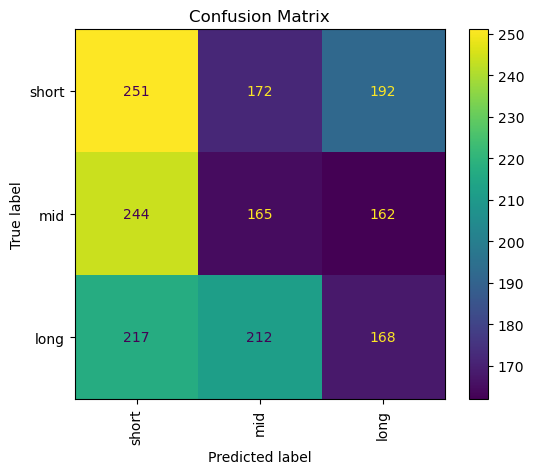

In [1389]:
class_names = ['short', 'mid', 'long']
plot_confusion_matrix(true_labels, predicted, class_names)